In [1]:
# Import necessary libraries for visualization, numerical operations, and quantum machine learning
import matplotlib.pyplot as plt
import numpy as np
from pennylane import numpy as pnp
from tqdm import tqdm
import pennylane as qml
import tensorflow as tf
from tensorflow import keras

2024-01-06 15:39:57.065084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 15:39:57.065131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 15:39:57.098268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 15:39:57.178590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 15:39:58.134700: W tensorflow/compiler/tf2

In [2]:
# Set the random seed for reproducibility
np.random_seed = 42

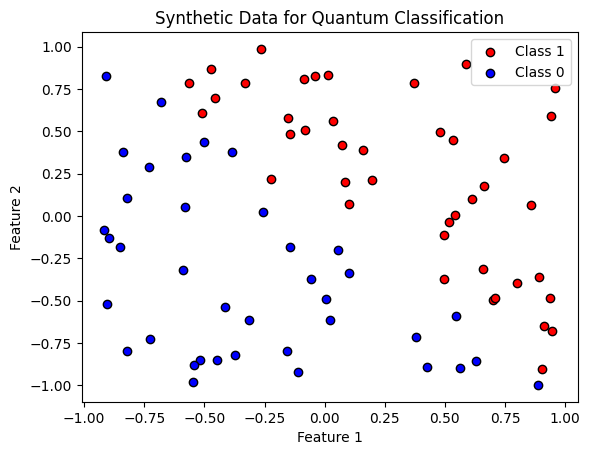

In [3]:
# Define the number of input features and number of samples
num_inputs = 2
num_samples = 80

# Generate random samples for training data
X = 2 * np.random.random((num_samples, num_inputs)) - 1

# Calculate the target labels based on the sum of features
y = np.sum(X, axis=1) >= 0  # True if sum is non-negative, False otherwise
# y_one_hot = np.zeros((num_samples, 2), dtype=int)
# y_one_hot[np.arange(num_samples), y.astype(int)] = 1
y = y.astype("int32")
y = y * 2 - 1
# Plotting the generated synthetic data
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', marker='o', edgecolors='k', label="Class 1")
plt.scatter(X[y == -1, 0], X[y == -1, 1], c='b', marker='o', edgecolors='k', label="Class 0")
plt.title("Synthetic Data for Quantum Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [4]:
# set the device
device = qml.device("default.qubit", wires=2)

In [5]:
def quantum_circuit(W):
    qml.CNOT(wires=[1, 0])
    
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    
    qml.CNOT(wires=[0, 1])

In [6]:
def preprocessing(x):
    qml.AngleEmbedding(x, wires=[0, 1])

In [7]:
@qml.qnode(device, diff_method="parameter-shift", max_diff=4)
def layer(weights, x):
    preprocessing(x)
    
    for W in weights:
        quantum_circuit(W)
    return qml.expval(qml.PauliZ(0))

In [8]:
def mean_squared_error(actual_values, predicted_values):
    n_samples = len(actual_values)
    squared_errors = [(actual - predicted) ** 2 for actual, predicted in zip(actual_values, predicted_values)]
    mse = sum(squared_errors) / n_samples
    return mse

In [9]:
def classifier(weight, bias, x):
    return layer(weight, x) + bias

In [10]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [11]:
def cost(weights, bias, X, Y):
    predictions = [classifier(weights, bias, x) for x in X]
    return mean_squared_error(Y, predictions)

In [12]:
X = pnp.array(X[:], requires_grad=False)
Y = pnp.array(y[:], requires_grad=False)

In [13]:
pnp.random.seed(0)
num_qubits = 2
num_layers = 1
weights_init = 0.01 * pnp.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = pnp.array(0.0, requires_grad=True)
print(weights_init, bias_init)

[[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]]] 0.0


/tmp/ipykernel_995/562676348.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


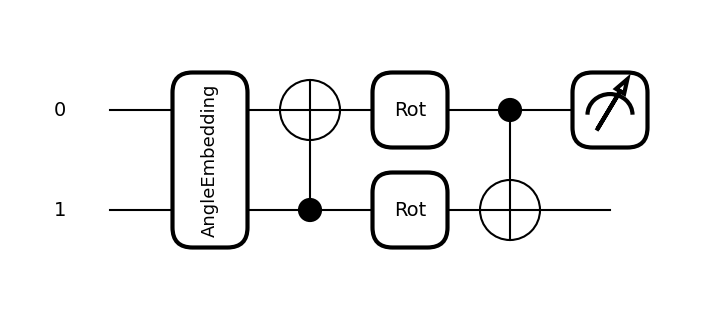

In [14]:
fig, ax = qml.draw_mpl(layer)(weights_init, X[0])
fig.show()

In [15]:
learning_rate = 0.02
# opt = qml.NesterovMomentumOptimizer(0.05)
batch_size = 4

In [16]:
weights = weights_init
bias = bias_init
for epoch in range(20):
    print(f"Starting epoch: {epoch + 1}")
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    
    grad_fn = qml.grad(cost)
    weights_grads, bias_grads = grad_fn(weights, bias, X_batch, Y_batch)
    bias = bias - bias_grads * learning_rate
    weights = weights - weights_grads * learning_rate
    

    # Compute accuracy
    predictions = [np.sign(classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print(f"Cost: {cost(weights, bias, X, Y)} Accuracy: {acc} ")

Starting epoch: 1
Cost: 1.3651065227868917 Accuracy: 0.525 
Starting epoch: 2
Cost: 1.3831081730398735 Accuracy: 0.525 
Starting epoch: 3
Cost: 1.3240135464822838 Accuracy: 0.525 
Starting epoch: 4
Cost: 1.3021734157188667 Accuracy: 0.525 
Starting epoch: 5
Cost: 1.3018545917513467 Accuracy: 0.525 
Starting epoch: 6
Cost: 1.3164514145573385 Accuracy: 0.525 
Starting epoch: 7
Cost: 1.3114245768675363 Accuracy: 0.525 
Starting epoch: 8
Cost: 1.2833923556790559 Accuracy: 0.525 
Starting epoch: 9
Cost: 1.2781205941612575 Accuracy: 0.525 
Starting epoch: 10
Cost: 1.2690028508404545 Accuracy: 0.525 
Starting epoch: 11
Cost: 1.2281141013437176 Accuracy: 0.525 
Starting epoch: 12
Cost: 1.186959812929112 Accuracy: 0.525 
Starting epoch: 13
Cost: 1.1721841060797764 Accuracy: 0.525 
Starting epoch: 14
Cost: 1.1904244317915984 Accuracy: 0.525 
Starting epoch: 15
Cost: 1.1897454868618644 Accuracy: 0.525 
Starting epoch: 16
Cost: 1.2121749845907026 Accuracy: 0.525 
Starting epoch: 17
Cost: 1.2125442

In [17]:
X_val = 2 * np.random.random((1000, 2)) - 1
y_val = np.sum(X_val, axis=1) >= 0  # Generate labels for the test data
y_val = y_val * 2 -1

In [18]:
y_pred = np.sign(classifier(weights, bias, X_val))

In [19]:
accuracy(y_val, y_pred)

0.489

In [20]:
opt = qml.NesterovMomentumOptimizer(0.01)

In [21]:
weights = weights_init
bias = bias_init
for epoch in range(10):
    print(f"Starting epoch: {epoch + 1}")
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print(f"Loss: {cost(weights, bias, X, Y)} Accuracy: {acc} ")

Starting epoch: 1
Loss: 1.3770080001582916 Accuracy: 0.525 
Starting epoch: 2
Loss: 1.3134062948902747 Accuracy: 0.525 
Starting epoch: 3
Loss: 1.2515630280201082 Accuracy: 0.525 
Starting epoch: 4
Loss: 1.1827134758715374 Accuracy: 0.525 
Starting epoch: 5
Loss: 1.1221779265892056 Accuracy: 0.525 
Starting epoch: 6
Loss: 1.0726546229362166 Accuracy: 0.5375 
Starting epoch: 7
Loss: 1.0388944227956285 Accuracy: 0.525 
Starting epoch: 8
Loss: 1.0126573893526911 Accuracy: 0.5125 
Starting epoch: 9
Loss: 0.9982309984091357 Accuracy: 0.55 
Starting epoch: 10
Loss: 0.9934392234483667 Accuracy: 0.5875 


In [22]:
X_val = 2 * np.random.random((1000, 2)) - 1
y_val = np.sum(X_val, axis=1) >= 0  # Generate labels for the test data
y_val = y_val * 2 -1

In [23]:
y_pred = np.sign(classifier(weights, bias, X_val))

In [24]:
accuracy(y_val, y_pred)

0.493

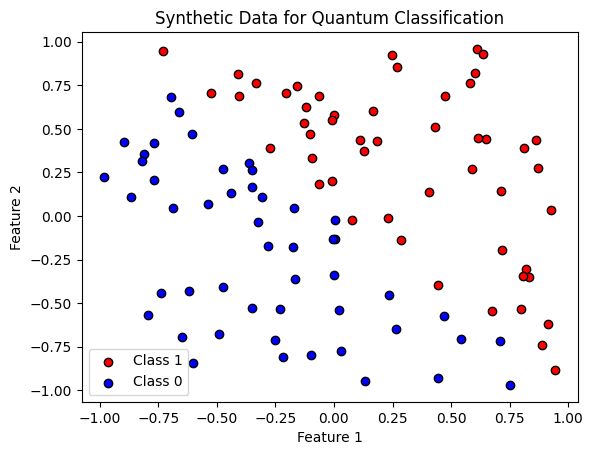

In [25]:
# Define the number of input features and number of samples
num_inputs = 2
num_samples = 100

# Generate random samples for training data
X = 2 * np.random.random((num_samples, num_inputs)) - 1

# Calculate the target labels based on the sum of features
y = np.sum(X, axis=1) >= 0  # True if sum is non-negative, False otherwise
y_one_hot = np.zeros((num_samples, 2), dtype=int)
y_one_hot[np.arange(num_samples), y.astype(int)] = 1

# Plotting the generated synthetic data
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', marker='o', edgecolors='k', label="Class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='b', marker='o', edgecolors='k', label="Class 0")
plt.title("Synthetic Data for Quantum Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [26]:
def quantum_circuit(W):
    qml.CNOT(wires=[1, 0])

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)

    qml.CNOT(wires=[0, 1])

In [27]:
def preprocessing(x):
    qml.AngleEmbedding(x, wires=[0, 1])

In [28]:
from pennylane import AngleEmbedding, StronglyEntanglingLayers

device = qml.device("default.qubit.tf", wires=2)
@qml.qnode(device, interface="tf")
def layer(weights, inputs):
    AngleEmbedding(inputs, wires=range(num_qubits))
    
    for weight in weights:
        quantum_circuit(weight)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

2024-01-06 15:40:08.570099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 15:40:08.766473: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 15:40:08.766536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 15:40:08.769614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 15:40:08.769663: I external/local_xla/xla/stream_executor

In [29]:
num_qubits = 2
num_layers = 2
epochs = 30

In [30]:
qlayer = qml.qnn.KerasLayer(layer, {"weights": (num_layers, num_qubits, 3)}, output_dim=num_qubits)
qlayer.trainable = True

In [31]:
preprocessing = tf.keras.layers.Dense(2, name="preprocessing", activation=None)
classical_output = tf.keras.layers.Dense(2, activation="softmax")
model = tf.keras.models.Sequential([qlayer, classical_output])

In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer, loss="mse", metrics=["categorical_accuracy"])#categorical_crossentropy


In [ ]:
fitting = model.fit(X, y_one_hot, epochs=30, batch_size=2, validation_split=0.2, verbose=1)

Epoch 1/30


2024-01-06 15:40:09.575393: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/40 [..............................] - ETA: 1:15 - loss: 0.3585 - categorical_accuracy: 0.5000

2024-01-06 15:40:11.070158: I external/local_xla/xla/service/service.cc:168] XLA service 0x1570ba60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-06 15:40:11.070188: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-01-06 15:40:11.091519: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1704552011.134940     995 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 [==============================] - 5s 73ms/step - loss: 0.3565 - categorical_accuracy: 0.5000 - val_loss: 0.3234 - val_categorical_accuracy: 0.5500
Epoch 2/30
14/40 [=========>....................] - ETA: 1s - loss: 0.3839 - categorical_accuracy: 0.4286WARNING:tensorflow:You are casting an input of type complex128 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


In [ ]:
model.evaluate(X, y_one_hot, batch_size=8)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(fitting.history['loss']), "-b", label="Training Loss")
plt.plot(np.array(fitting.history['val_loss']), "-r", label="Validation Loss")
plt.title("Training and Validation Loss Aver Time")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(fitting.history['categorical_accuracy']), "-b", label="Training Accuracy")
plt.plot(np.array(fitting.history['val_categorical_accuracy']), "-r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy Aver Time")
plt.legend()
plt.show()